# Setup and load

In [17]:
import pandas as pd
import numpy as np
import os
import sys
import warnings

import backtrader as bt
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

In [23]:
# Set the path to the root directory
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(path)

# Load Model 3 prediction file
df = pd.read_csv(path + '/data/predictions/Ny modell run.csv')

# Filter between 2018-01-01 and 2018-06-30
df = df[(df["Quote_date"] >= "2018-01-01") & (df["Quote_date"] <= "2018-01-10")]

# Print the first and last Quote_date for df3
print("First Quote_date for df: ", df["Quote_date"].iloc[0])
print("Last Quote_date for df: ", df["Quote_date"].iloc[-1])

# Print the length of df3
print("Length of df: ", len(df))

# In df3, change "Predictions" column name to Model 3
df = df.rename(columns={"Prediction": "Model 3"})


First Quote_date for df:  2018-01-02
Last Quote_date for df:  2018-01-10
Length of df:  28360


### Config

In [24]:
buy_threshold = 0
sell_threshold = 9

# Main

In [27]:
import pandas as pd
import numpy as np

def generate_signals(df, buy_threshold, sell_threshold):
    buy_signal = (df['Model 3'] - df['Price']) >= buy_threshold
    sell_signal = (df['Price'] - df['Model 3']) >= sell_threshold
    return buy_signal, sell_signal

def calculate_profit(df, buy_signal, sell_signal):
    original_df = df.copy()  # Create a copy of the original DataFrame
    df['Signal'] = 0
    df.loc[buy_signal, 'Signal'] = 1
    df.loc[sell_signal, 'Signal'] = -1
    df['Expiry_date'] = pd.to_datetime(df['Quote_date']) + pd.to_timedelta(df['TTM'] * 365, unit='D')
    last_date = df['Quote_date'].max()
    df = df[df['Expiry_date'] <= last_date]
    num_trade_opportunities = len(df)
    df = df[(buy_signal) | (sell_signal)]  # Add this line to filter the DataFrame
    groups = df.groupby(['Expiry_date', 'Strike'])

    profit_df = pd.DataFrame(columns=list(df.columns) + ['Profit'])

    for _, group in groups:

        # Sort group so that the last row is the one with the lowest TTM
        group = group.sort_values(by='TTM')

        last_row = group.iloc[-1]

        expiry_date = last_row['Expiry_date']
        # Expiry_date to string
        expiry_date = expiry_date.strftime('%Y-%m-%d')
        
        underlying_last_on_expiry = original_df.loc[original_df['Quote_date'] == expiry_date, 'Underlying_last'].iloc[0]
        intrinsic_value = np.maximum(underlying_last_on_expiry - last_row['Strike'], 0)

        group['Profit'] = group['Signal'] * (intrinsic_value - group['Price'])
        profit_df = profit_df.append(group)

    return profit_df, num_trade_opportunities



buy_signal, sell_signal = generate_signals(df, buy_threshold, sell_threshold)
profit_df, num_trade_opportunities = calculate_profit(df, buy_signal, sell_signal)
total_profit = profit_df['Profit'].sum()
num_trades = profit_df['Signal'].abs().sum()

print(f"Total Profit: {total_profit:.2f}")
print(f"Number of trade opportunities: {num_trade_opportunities}")
print(f"Number of Trades: {num_trades}")

if num_trades > 0:
    average_profit = total_profit / num_trades
    print(f"Average Profit per Trade: {average_profit:.2f}")
else:
    print("No trades were executed.")


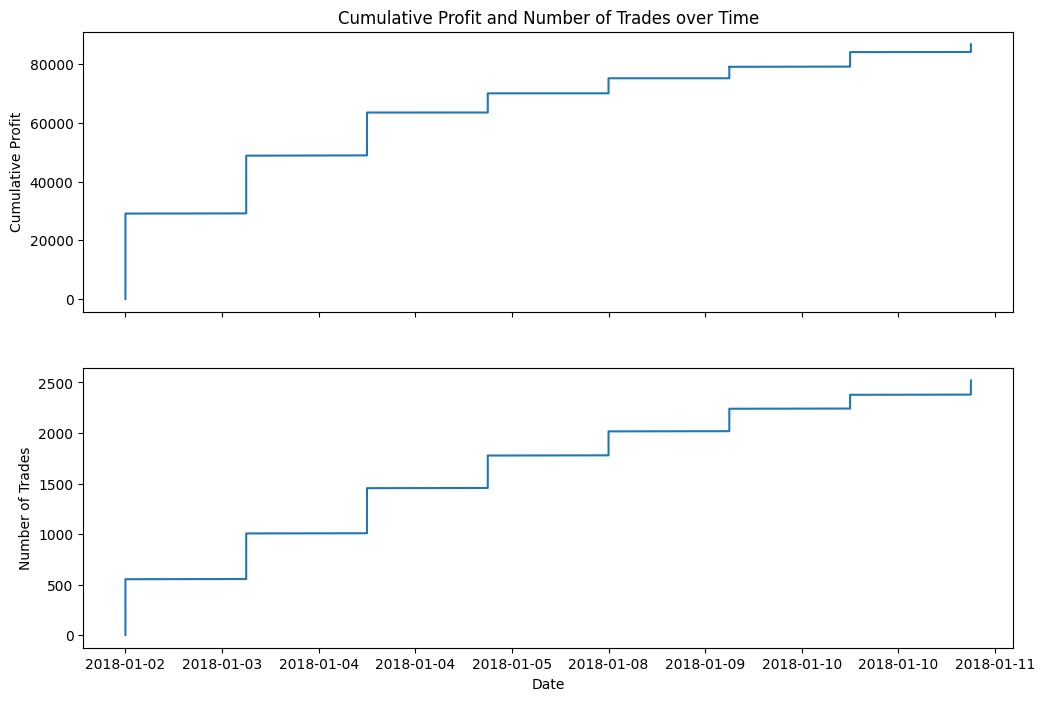

In [ ]:
import matplotlib.pyplot as plt

def visualize_results(profit_df):
    # Sort the DataFrame by 'Quote_date'
    profit_df = profit_df.sort_values(by='Quote_date')
    
    # Calculate cumulative profit over time
    profit_df['Cumulative_Profit'] = profit_df['Profit'].cumsum()
    
    # Create a figure with two subplots: one for profit and one for the number of trades
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Plot the cumulative profit over time on the first subplot
    ax1.plot(profit_df['Quote_date'], profit_df['Cumulative_Profit'])
    ax1.set_ylabel('Cumulative Profit')
    ax1.set_title('Cumulative Profit and Number of Trades over Time')
    # Set the interval for x-axis labels
    ax1.xaxis.set_major_locator(plt.MaxNLocator(10))

    # Calculate and plot the number of trades executed over time on the second subplot
    profit_df['Num_Trades'] = profit_df['Signal'].abs().cumsum()
    ax2.plot(profit_df['Quote_date'], profit_df['Num_Trades'])
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Number of Trades')

    plt.show()

# Call the function to visualize the results
visualize_results(profit_df)

# Fint best thresholds

In [ ]:
df = df_read.copy()

def find_best_thresholds(df, min_threshold, max_threshold, step):
    best_buy_threshold = 0
    best_sell_threshold = 0
    best_profit = float('-inf')
    best_num_trades = 0

    for buy_threshold in np.arange(min_threshold, max_threshold, step):
        for sell_threshold in np.arange(min_threshold, max_threshold, step):
            df = df_read.copy()
            buy_signal, sell_signal = generate_signals(df, buy_threshold, sell_threshold)
            profit_df = calculate_profit(df, buy_signal, sell_signal)
            total_profit = profit_df['Profit'].sum()
            num_trades = profit_df['Signal'].abs().sum()

            if total_profit > best_profit:
                best_profit = total_profit
                best_buy_threshold = buy_threshold
                best_sell_threshold = sell_threshold
                best_num_trades = num_trades

    return best_buy_threshold, best_sell_threshold, best_profit, best_num_trades

best_buy_threshold, best_sell_threshold, best_profit, best_num_trades = find_best_thresholds(df, 0, 12, 3)

print(f"Best Buy Threshold: {best_buy_threshold:.2f}")
print(f"Best Sell Threshold: {best_sell_threshold:.2f}")
print(f"Best Profit: {best_profit:.2f}")
print(f"Best Number of Trades: {best_num_trades}")

NameError: name 'df_read' is not defined